In [2]:
# numerics + rv stuff
import numpy as np
import scipy as sp
from scipy.stats.distributions import chi2
from scipy.sparse import coo_matrix
from scipy.sparse import linalg
from numpy.random import default_rng
# plotting + misc tools
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools as it
from copy import deepcopy
import matplotlib.colors as colors
import seaborn
import pandas as pd

# rng setup
rng = default_rng(100496)

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams.update({"figure.facecolor": "white"})

# set numpy print option to a more readable format for floats
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

## Analysis of complex demographic scenarios from PReFerSim

In this file, I will simulate changing population sizes and increase the level of complexity with each simulation. 
1. Bottleneck.txt with point prob selection coefficient ($s=-0.00125$ or $\gamma=-20$ for $N_e=10,000$) and sampling 500 inds ($n=1000$) in the present
(simplification of OOA bottleneck, 20k inds 10k gens ago, followed by 2k inds 2k gens ago)
`(https://github.com/dortegadelv/HaplotypeDFEStandingVariation/blob/master/Scripts/Sims/AncientBottleneck/ForwardSims/ParameterFile_4Ns-50.txt)`

In [16]:
%load_ext autoreload
%autoreload 2
from mom_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
## Need to create look-up tables matching the above demographic history...also run the gamma search over a relevant grid
gamma = -np.logspace(0,2,20)
n = 1000
N = 20000
mu = 1.2e-8
cutoff = 1 # freq of 0.5%

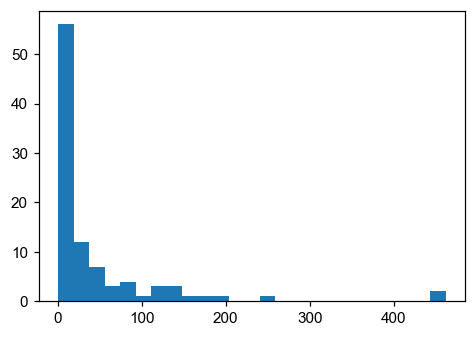

(array([1.000, 1.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 1.000,
        0.000, 0.000, 0.000, 2.000, 2.000, 0.000, 3.000, 1.000, 2.000,
        1.000, 1.000, 4.000, 1.000, 9.000, 12.000, 54.000]),
 array([19659.000, 19752.600, 19846.200, 19939.800, 20033.400, 20127.000,
        20220.600, 20314.200, 20407.800, 20501.400, 20595.000, 20688.600,
        20782.200, 20875.800, 20969.400, 21063.000, 21156.600, 21250.200,
        21343.800, 21437.400, 21531.000, 21624.600, 21718.200, 21811.800,
        21905.400, 21999.000]),
 <BarContainer object of 25 artists>)

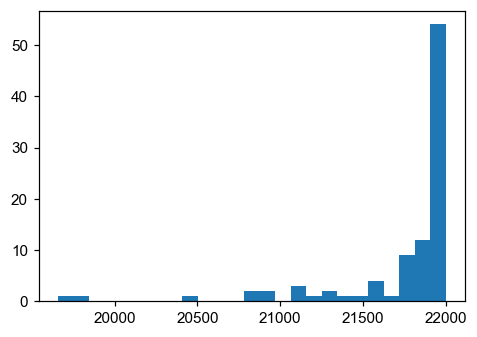

In [28]:
## reading in simulated data + exploratory analysis
df1 = pd.read_csv("PReFerSims/outfiles/Bottleneck.1.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
df1
df1['sXl'] = rng.binomial(n=n, p=df1['Xl'])
df1['al'] = 12001 - df1['al']
dat = df1.to_numpy()
plt.hist(df1['sXl'],25); plt.show()
plt.hist(df1['al'],25)

In [70]:
## creating a database of P(X, a | s) with dicts for different s values
up_xa_s = {}
Nc = np.concatenate((np.repeat(20000,10000),np.repeat(2000,2000)))
for ig, g in enumerate(gamma):
    # unscaled probability - almost likelihood
    up_xa_s[g] = run_mom_iterate_changing(n, 0.5*g/N, Nc, mu, misc = {'dt_fac':0.02, 'adapt_dt':True})

p_xa_s = {}
for g in gamma:
    up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)] = up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)]/np.sum(up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)])
    p_xa_s[g] = np.sum(up_xa_s[g], axis=0)

[]

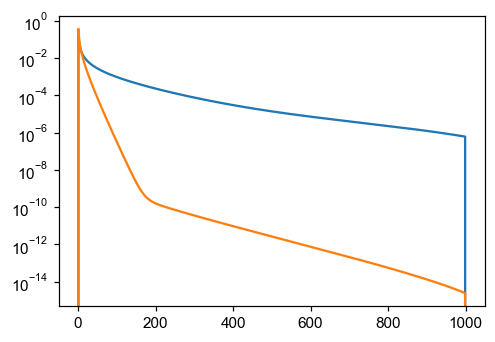

In [73]:
## inference procedure (plot the loglik surfaces)
# sin_onlyfreq = np.empty(len(gamma))
# sin_onlyage = np.empty(len(gamma))
for ig, g in enumerate(gamma):
    # sum log prob for each locus
    sin_onlyfreq[ig] = np.sum(get_lp_xl(p_xa_s, g, dat[:,5], cutoff=1))
    sin_onlyage[ig] = np.sum(get_lp_alxl(up_xa_s, g, dat[:,5], dat[:,3], cutoff=1))

In [74]:
densegrid = -np.logspace(0,2,base=10,num=100)
lxlbfq = get_bfq(sin_onlyfreq-np.max(sin_onlyfreq), gamma) @ np.vstack((densegrid**2, densegrid,np.repeat(1.0,100)))
lxlalbfq = get_bfq(sin_onlyage-np.max(sin_onlyage), gamma) @ np.vstack((densegrid**2, densegrid,np.repeat(1.0,100)))

-1.0
-1.0


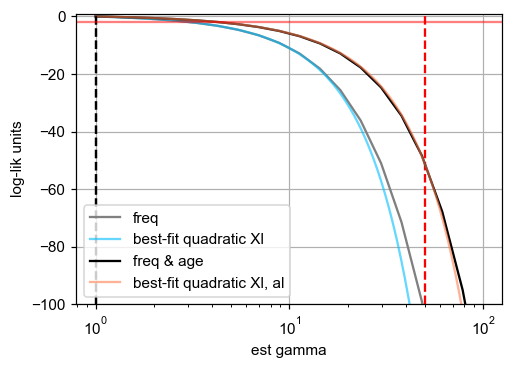

In [75]:
plt.plot(-gamma, sin_onlyfreq-np.max(sin_onlyfreq),'grey', label='freq'); plt.ylim((-100,1)); plt.xlabel('est gamma')
plt.axvline(-gamma[np.argmax(sin_onlyfreq)], color='grey', linestyle='--'); plt.semilogx(); 
plt.plot(-densegrid, lxlbfq-np.max(lxlbfq), color='deepskyblue', alpha=0.6,label='best-fit quadratic Xl');
plt.axvline(df1['s'][0]*2*Nc[0], color='red', ls='--')
print(gamma[np.argmax(sin_onlyfreq)])
plt.plot(-gamma, sin_onlyage-np.max(sin_onlyage),'k', label='freq & age'); plt.ylim((-100,1)); plt.semilogx()
plt.plot(-densegrid, lxlalbfq-np.max(lxlalbfq), color='coral', alpha=0.6,label='best-fit quadratic Xl, al');
plt.axvline(-gamma[np.argmax(sin_onlyage)], color='k', linestyle='--'); plt.ylabel('log-lik units'); plt.legend(); plt.grid()
print(gamma[np.argmax(sin_onlyage)])
plt.axhline(-2.,color='red',alpha=0.5)